In [1]:
%matplotlib inline
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.solvers import Solver2D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.generators import Generator2D
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from neurodiffeq.conditions import IBVP1D
from neurodiffeq.pde import make_animation

Training Progress:   0%|                                                                       | 0/200 [00:00<…

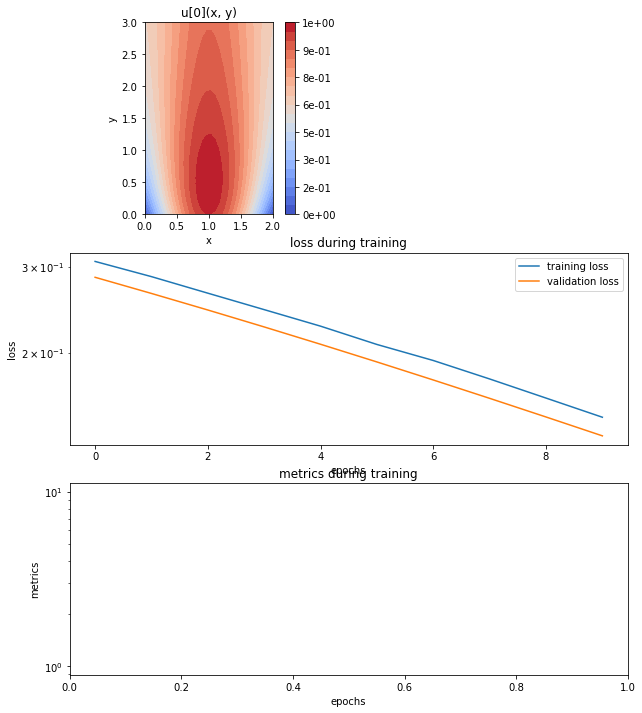

In [2]:
k, L, T = 0.3, 2, 3
# Define the PDE system
# There's only one (heat) equation in the system, so the function maps (u, x, y) to a single entry
heat = lambda u, x, t: [
    diff(u, t) - k * diff(u, x, order=2)
]

# Define the initial and boundary conditions
# There's only one function to be solved for, so we only have a single condition object
conditions = [
    IBVP1D(
        t_min=0, t_min_val=lambda x: torch.sin(np.pi * x / L),
        x_min=0, x_min_prime=lambda t:  np.pi/L * torch.exp(-k*np.pi**2*t/L**2),
        x_max=L, x_max_prime=lambda t: -np.pi/L * torch.exp(-k*np.pi**2*t/L**2)
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets = [
    FCNN(n_input_units=2, hidden_units=(32, 32))
]


# Define the monitor callback
monitor=Monitor2D(check_every=10, xy_min=(0, 0), xy_max=(L, T))
monitor_callback = monitor.to_callback()

# Instantiate the solver
solver = Solver2D(
    pde_system=heat,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(L, T),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets,
    train_generator=Generator2D((32, 32), (0, 0), (L, T), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (L, T), method='equally-spaced'),
)

# Fit the neural network
solver.fit(max_epochs=200, callbacks=[monitor_callback])

# Obtain the solution
solution_neural_net_heat = solver.get_solution()

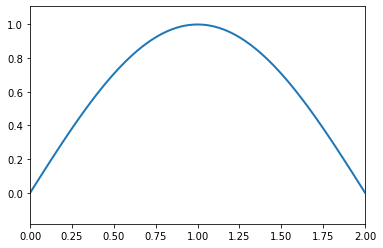

In [4]:
xs = np.linspace(0, L, 101)
ts = np.linspace(0, T, 101)
xx, tt = np.meshgrid(xs, ts)
make_animation(solution_neural_net_heat, xs, ts)

C:\Users\mesej\AppData\Local\Temp\ipykernel_16228\2455221882.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax   = Axes3D(fig)


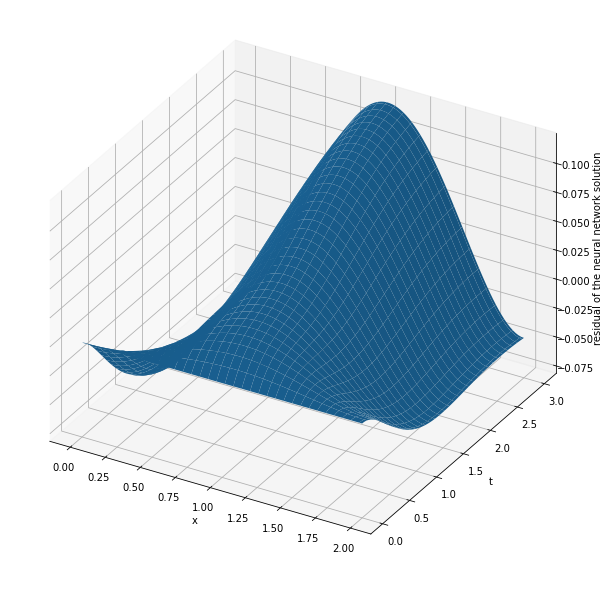

In [5]:
def plt_surf(xx, yy, zz, z_label='u', x_label='x', y_label='y', title='',
             save='PlotsMay11/SolutionAloneN=8'):
    fig  = plt.figure(figsize=(16, 8))
    ax   = Axes3D(fig)
    surf = ax.plot_surface(xx, yy, zz)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    ax.set_proj_type('ortho')
    # plt.savefig(save)
    plt.show()

    
solution_analytical_heat = lambda x, t: np.sin(np.pi*x/L) * np.exp(-k * np.pi**2 * t / L**2)
sol_ana = solution_analytical_heat(xx, tt)
sol_net = solution_neural_net_heat(xx, tt, to_numpy=True)
plt_surf(xx, tt, sol_net-sol_ana, y_label='t', z_label='residual of the neural network solution')